In [1]:
# Basic Libraries Needed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from env import host, user, password
import os

from sklearn.model_selection import train_test_split

import wrangle

# Remove the angry pink boxes
import warnings
warnings.filterwarnings("ignore")


1. Acquire `bedroomcnt`, `bathroomcnt`, `calculatedfinishedsquarefeet`, `taxvaluedollarcnt`, `yearbuilt`, `taxamount`, and `fips` from the zillow database for all 'Single Family Residential' properties.


In [2]:
def get_connection(database_name):
    '''
    This function takes in a string representing a database name for the Codeup mySQL server 
    and returns a string that can be used to open a connection to the server.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{database_name}'


In [3]:
def get_zillow_data():
    '''
    This function reads the Zillow database from the Codeup mySQL server and  returns a dataframe.
    If a local file does not exist, this function writes data to a csv file as a backup. The local file 
    ensures that data can be accessed, in the event that you cannot talk to the mySQL database. 
    '''
    # The filename will have 2017 at the end to represent that the only data being looked at is 
    # properties from the year 2017
    if os.path.isfile('zillow2017.csv'):
        # If csv file exists read in data from csv file.
        df = pd.read_csv('zillow2017.csv', index_col=0)
        
    else:
        
        # Read fresh data from database into a DataFrame
        # property land use type id is limited to 'Single Family Residential' properties.
        df =  pd.read_sql(""" SELECT bedroomcnt, 
                                     bathroomcnt, 
                                     calculatedfinishedsquarefeet, 
                                     taxvaluedollarcnt, 
                                     yearbuilt, 
                                     taxamount, 
                                     fips
                              FROM properties_2017
                              WHERE propertylandusetypeid = 261;""", 
                            get_connection('zillow')
                        )
        # Cache data into a csv backup
        df.to_csv('zillow2017.csv')
    
    # Renaming column names to one's I like better
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})   
    return df

#### I will not add inferred family housing cause there is only one row full of nulls

In [4]:
zillow = get_zillow_data()
zillow.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


2. Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.


In [5]:
zillow.shape

(2152863, 7)

In [6]:
# Average bedroom count is 3
# Average bathroom count is 2
zillow.describe()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips
count,2.152852e+06,2.152852e+06,2.144379e+06,2.152370e+06,2.143526e+06,2.148421e+06,2.152863e+06
mean,3.287196e+00,2.230688e+00,1.862855e+03,4.618962e+05,1.960950e+03,5.634866e+03,6.048377e+03
std,9.547544e-01,9.992796e-01,1.222125e+03,6.996760e+05,2.216220e+01,8.178910e+03,2.043329e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.801000e+03,1.850000e+00,6.037000e+03
25%,3.000000e+00,2.000000e+00,1.257000e+03,1.881702e+05,1.949000e+03,2.534980e+03,6.037000e+03
50%,3.000000e+00,2.000000e+00,1.623000e+03,3.276710e+05,1.958000e+03,4.108950e+03,6.037000e+03
75%,4.000000e+00,3.000000e+00,2.208000e+03,5.345270e+05,1.976000e+03,6.414320e+03,6.059000e+03
max,2.500000e+01,3.200000e+01,9.525760e+05,9.842891e+07,2.016000e+03,1.337756e+06,6.111000e+03


In [7]:
# Verbose and null_counts made true, because this dataset is a bit larger
zillow.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedrooms    2152852 non-null  float64
 1   bathrooms   2152852 non-null  float64
 2   area        2144379 non-null  float64
 3   tax_value   2152370 non-null  float64
 4   year_built  2143526 non-null  float64
 5   taxamount   2148421 non-null  float64
 6   fips        2152863 non-null  float64
dtypes: float64(7)
memory usage: 131.4 MB


In [8]:
# I know there are null values, but I don't know how many:
zillow.isnull().sum()

bedrooms        11
bathrooms       11
area          8484
tax_value      493
year_built    9337
taxamount     4442
fips             0
dtype: int64

#### Null_Counts by Percentage  
bedroomcnt                        0.000005%  
bathroomcnt                       0.000005%  
calculatedfinishedsquarefeet      0.0039%  
taxvaluedollarcnt                 0.000229%  
yearbuilt                         0.0043%  
taxamount                         0.0021  
fips                              0%  

In [9]:
# Total count of all Nulls is 1.06% of all data. 
# I think it would be safe to drop all nulls and not have it affect my data
zillow.isnull().sum().sum()

22778

In [10]:
# These numbers don't add up, I better check again
print(zillow.shape)
zillow = zillow.dropna()
print(zillow.shape)

(2152863, 7)
(2140235, 7)


In [11]:
# Checking to make sure everything looks right
zillow.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
taxamount     0
fips          0
dtype: int64

In [12]:
zillow.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedrooms    2140235 non-null  float64
 1   bathrooms   2140235 non-null  float64
 2   area        2140235 non-null  float64
 3   tax_value   2140235 non-null  float64
 4   year_built  2140235 non-null  float64
 5   taxamount   2140235 non-null  float64
 6   fips        2140235 non-null  float64
dtypes: float64(7)
memory usage: 130.6 MB


#### Notes:
- I should probably change yearbuilt to an INT since years dont have decimals

- Also, I googled fips because I didn't know what it was:  
    - Federal Information Processing System (FIPS) Codes for States and Counties. 
    - FIPS codes are numbers which uniquely identify geographic areas.

- It looks like fips are whole numbers, so I'll make that an int too!  
- Bathrooms are known to have wierd numbers like 2.5 Bath, so float makes sense  
- I'm not entirely sure a 2.5 Bedroom makes sense, but I'll leave that for now.  
- Squarefeet can definitely have a decimal  
- And tax dollars is money, so a float works just fine here


In [13]:
zillow["year_built"] = zillow.year_built.astype(int)
zillow["fips"] = zillow.fips.astype(int)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   area        float64
 3   tax_value   float64
 4   year_built  int64  
 5   taxamount   float64
 6   fips        int64  
dtypes: float64(5), int64(2)
memory usage: 130.6 MB


In [14]:
# Rajaram is a realtor and says he's never seen a bedroom count represented as a decimal
# I'm going to check and see if any of the bedroom counts utilize this decimal
zillow.bedrooms[(zillow.bedrooms % 1) != 0]

Series([], Name: bedrooms, dtype: float64)

#### Since there are no bedroom counts with anything after the zero, I can safely turn this column into an INT as well

In [15]:
zillow["bedrooms"] = zillow.bedrooms.astype(int)

In [16]:
# Somthing caught my eye. Are any of the categories zero? So they passed the null test but still have no value?
zillow[(zillow.bathrooms == 0) | (zillow.bedrooms == 0) | (zillow.area == 0)]

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips
11,0,0.0,1200.0,5328.0,1972,91.60,6037
14,0,0.0,171.0,6920.0,1973,255.17,6037
15,0,0.0,203.0,14166.0,1960,163.79,6037
398,3,0.0,2239.0,396608.0,1988,4404.22,6111
753,3,0.0,2421.0,1111120.0,1976,12394.16,6111
...,...,...,...,...,...,...,...
2149054,0,0.0,938.0,56733.0,1978,986.86,6037
2151453,2,0.0,1108.0,937075.0,1932,10851.50,6059
2152505,0,0.0,240.0,31234.0,1942,414.04,6037
2152704,0,1.0,1490.0,152000.0,1930,3614.40,6037


In [17]:
zillow.bedrooms.value_counts

<bound method IndexOpsMixin.value_counts of 4          4
6          3
7          3
11         0
14         0
          ..
2152856    4
2152858    4
2152859    4
2152861    3
2152862    4
Name: bedrooms, Length: 2140235, dtype: int64>

#### That's another 5326 rows of data with zeros where there should be numbers. 
Could this represent a vacant lot that hasn't been built yet? It seems that there is a separate category for this in the database called "Vacant Land - General".

- (5,326 / 2,152,863) that's less than 1% of our original data.
- If I drop these 5326 plus the rows with nulls, I will still have only loss approx 1% of my data. Since this shouldn't be enough to affect my data, I shall proceed.

In [18]:
print(zillow.shape)
zillow = zillow[(zillow.bathrooms != 0) | (zillow.bedrooms != 0)]
print(zillow.shape)

(2140235, 7)
(2136890, 7)


In [19]:
# We learned about outliers so I'm just gonna check and see if any data gets dropped for being considered an outlier
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [20]:
zillow.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips
4,4,2.0,3633.0,296425.0,2005,6941.39,6037
6,3,4.0,1620.0,847770.0,2011,10244.94,6037
7,3,2.0,2077.0,646760.0,1926,7924.68,6037
18,3,1.0,1244.0,169471.0,1950,2532.88,6037
19,3,2.0,1300.0,233266.0,1950,3110.99,6037


In [21]:
z = remove_outliers(zillow, 1.5, ['bedrooms', 
                                  'bathrooms', 
                                  'area', 
                                  'tax_value', 
                                  'taxamount'])

# Removing these outliers would remove 282,604 rows of data
zillow.shape[0] - z.shape[0]

282604

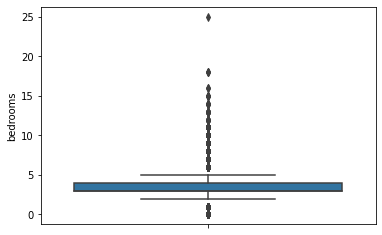

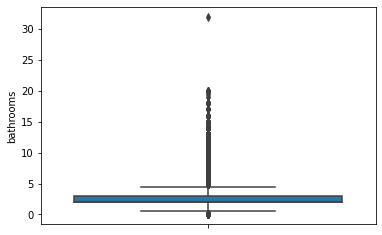

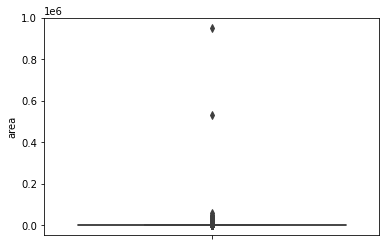

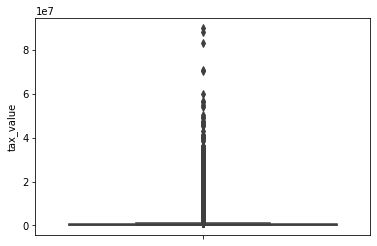

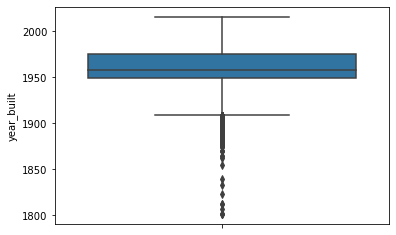

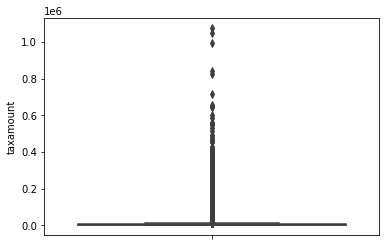

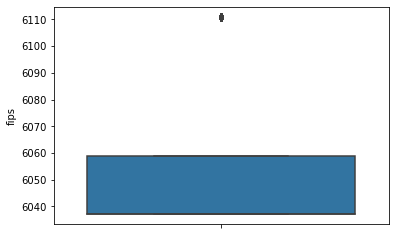

In [22]:
# Create boxplots for each column
columns = zillow.columns

for x in columns:
    sns.boxplot(data= zillow, y = x)
    plt.title('')

    plt.show()

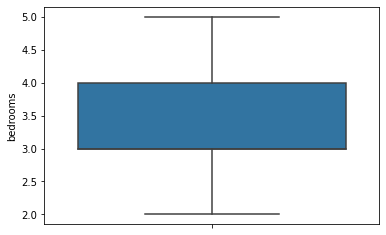

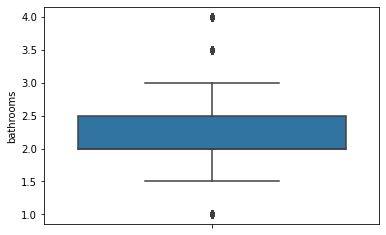

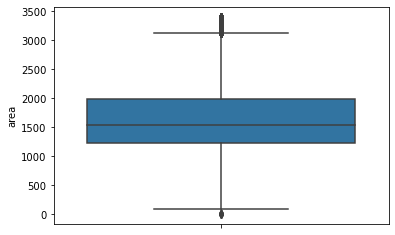

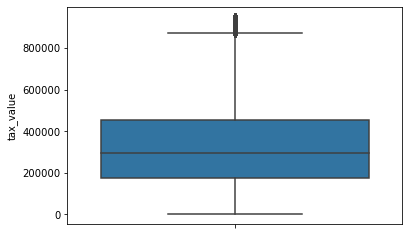

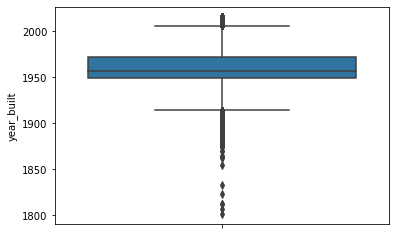

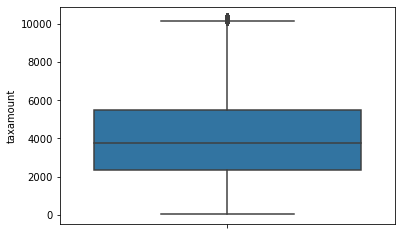

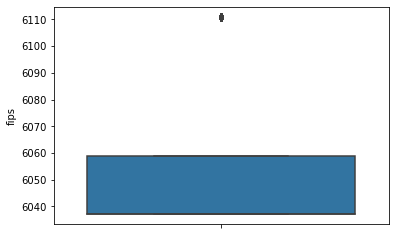

In [23]:
# Create boxplots for each column
columns = zillow.columns

for x in columns:
    sns.boxplot(data= z, y = x)
    plt.title('')

    plt.show()

In [24]:
zw = remove_outliers(z, 1.5, [    'bedrooms', 
                                  'bathrooms', 
                                  'area', 
                                  'tax_value', 
                                  'taxamount'])

# Removing these outliers would remove another 453,958 rows of data
z.shape[0] - zw.shape[0]

453958

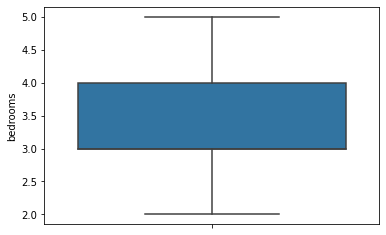

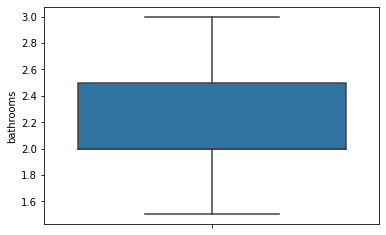

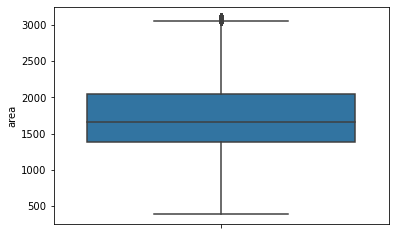

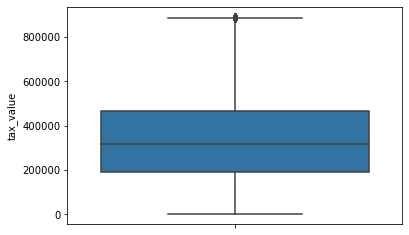

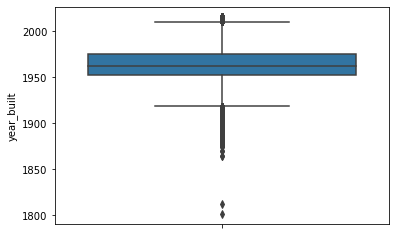

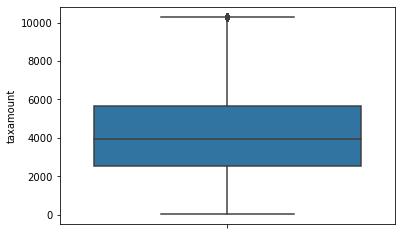

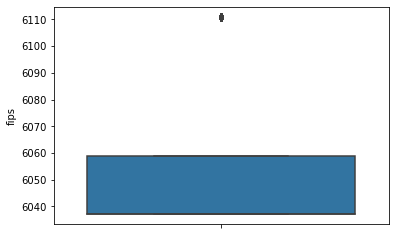

In [25]:
# Create boxplots for each column
columns = zillow.columns

for x in columns:
    sns.boxplot(data= zw, y = x)
    plt.title('')

    plt.show()

### The removal of outliers is not a formula, but human resoning of what's reasonable to keep. Most Single Family Homes on zillow are probably being looked at by people who buy normal sized houses (not  24 bedroom mansions). Also, depending on location, I can limit my price range to people who would actually use zillow. (Kim Kardashian isn't looking for her next multi-million dollar house on Zillow).

In [26]:
# make a note of where most of the fips are

In [27]:
# The instructor showed us his renamed coumns and i dig it. I'm gonna add it to my acquire step

# Renaming column names to one's I like better
zillow = zillow.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built',})

#### I can't think of anything else to clean up, so I think I'm good to combine all this into a function!

3. Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.


In [28]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

def prepare_zillow (zillow):
    # Remove extreme outliers (there will still be a few, but our data should be less skewed)
    zillow = remove_outliers(zillow, 1.5, ['bedrooms', 'bathrooms', 'area', 'tax_value', 'taxamount'])
    
    # Drop all data with nulls and zeros. This about 1.06% of the data, so shouldn't affect modeling
    zillow = zillow.dropna()
    zillow = zillow[(zillow.bathrooms != 0) | (zillow.bedrooms != 0)]
    
    # Change the data types of these columns to int
    zillow["year_built"] = zillow.year_built.astype(int)
    zillow["fips"] = zillow.fips.astype(int)
    zillow["bedrooms"] = zillow.bedrooms.astype(int)
    
    return zillow

def wrangle_zillow():
    '''Acquire and prepare data from Zillow database for explore'''
    # Acquire and Prep
    zillow = prepare_zillow(get_zillow_data())
    
    # Split
    train_validate, test = train_test_split(zillow, test_size=.2, random_state= 42)
    train, validate = train_test_split(train_validate, test_size=.3, random_state= 42)
    
    return train, validate, test

In [29]:
train, validate, test = wrangle_zillow()
train.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips
1901200,2,2.0,1205.0,354670.0,1941,4395.55,6037
1786912,5,2.0,1586.0,192000.0,2004,3114.34,6037
930919,2,1.0,860.0,212332.0,1952,2692.90,6037
1805072,2,1.0,1125.0,628500.0,1948,8168.31,6037
1775847,3,2.5,1731.0,532000.0,2002,5724.10,6111


In [30]:
train, validate, test = wrangle.wrangle_zillow()
train.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips
1901200,2,2.0,1205.0,354670.0,1941,4395.55,6037
1786912,5,2.0,1586.0,192000.0,2004,3114.34,6037
930919,2,1.0,860.0,212332.0,1952,2692.90,6037
1805072,2,1.0,1125.0,628500.0,1948,8168.31,6037
1775847,3,2.5,1731.0,532000.0,2002,5724.10,6111
